In [1]:
# %%
import numpy as np
import json
from livecellx.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,

)
from livecellx.core.single_cell import get_time2scs
from livecellx.core.datasets import LiveCellImageDataset
from livecellx.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from typing import List

# %% [markdown]
# Loading Mitosis trajectory Single Cells

# %%
sctc_path = r"../datasets/DIC-Nikon-gt/tifs_CFP_A549_VIM_120hr_NoTreat_NA_YL_Ti2e_2023-03-22/GH-XY03_traj/traj_XY03.json"
sctc = SingleCellTrajectoryCollection.load_from_json_file(sctc_path)

2024-04-15 04:03:29.970290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 04:03:29.970323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 04:03:29.971681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 04:03:29.977415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 04:03:30.602348: W tensorflow/compiler/tf2

|-----> json loaded from ../datasets/DIC-Nikon-gt/tifs_CFP_A549_VIM_120hr_NoTreat_NA_YL_Ti2e_2023-03-22/GH-XY03_traj/traj_XY03.json
|-----> Creating SingleCellTrajectoryCollection from json_dict...


In [2]:
scs = sctc.get_all_scs()
scs_by_time = get_time2scs(scs)

In [3]:
len(scs)

34735

In [4]:

def create_label_mask_from_scs(scs: List[SingleCellStatic], labels=None):
    label_mask = np.zeros(scs[0].get_mask().shape, dtype=np.int32)
    if labels is None:
        labels = list(range(1, len(scs) + 1))
    for idx, sc in enumerate(scs):
        label_mask[sc.get_mask()] = labels[idx]
    return label_mask

In [5]:
import tqdm
def compute_scs_iou(scs_from: List[SingleCellStatic], scs_to: List[SingleCellStatic], key="iou"):
    for sc1 in scs_from:
        if key not in sc1.tmp:
            sc1.tmp[key] = {}
        for sc2 in scs_to:
            if sc2 in sc1.tmp[key]:
                pass
            else:
                sc1.tmp[key][sc2] = sc1.compute_iou(sc2)

def compute_scs_iomin(scs_from: List[SingleCellStatic], scs_to: List[SingleCellStatic], key="iomin"):
    for sc1 in scs_from:
        if key not in sc1.tmp:
            sc1.tmp[key] = {}
        for sc2 in scs_to:
            if sc2 in sc1.tmp[key]:
                pass
            else:
                sc1.tmp[key][sc2] = sc1.compute_iomin(sc2)


def find_maps(scs_from: List[SingleCellStatic], scs_to: List[SingleCellStatic], metric_threshold=0.3, metric_key="iomin", min_map_num=None, metric="iomin"):
    if metric == "iou":
        compute_scs_iou(scs_from, scs_to,metric_key)
    elif metric == "iomin":
        compute_scs_iomin(scs_from, scs_to, metric_key)
    else:
        raise ValueError(f"Unknown metric: {metric}")
    scs_map = {}
    for sc1 in scs_from:
        scs_map[sc1] = []
        for sc2 in scs_to:
            if sc1.tmp[metric_key][sc2] > metric_threshold:
                scs_map[sc1].append(sc2)
    # Filter by length of scs_map elements
    if min_map_num is not None:
        scs_map = {k: v for k, v in scs_map.items() if len(v) >= min_map_num}
    return scs_map


# compute_scs_iou(scs_by_time[0], scs_by_time[1])
find_maps(scs_by_time[0], scs_by_time[1])
scs_by_time[0][0].tmp.keys()

dict_keys(['iomin'])

In [6]:
img_dataset = scs[0].img_dataset

In [7]:
out_dir = Path("./tmp/EBSS_120hrs_OU_syn")

In [8]:
# total_time=4 # For debug
# interval = 1
total_time = len(scs_by_time)
interval = 50

Unparalleled version

In [9]:
# import skimage
# from skimage.segmentation import watershed
# from skimage.feature import peak_local_max
# from skimage import measure
# from skimage import filters
# import skimage.segmentation
# from scipy import ndimage

# from livecellx.core.io_sc import process_scs_from_single_label_mask
# from livecellx.preprocess.utils import dilate_or_erode_label_mask
# import tqdm


# check_fig_out = out_dir / "crappy_seg_check"
# crapp_mask_out = out_dir / "crappy_seg_mask"
# check_fig_out.mkdir(exist_ok=True, parents=True)
# crapp_mask_out.mkdir(exist_ok=True, parents=True)

# crappy_scs_by_time = {}

# underseg_dilate_scales = np.linspace(0, 2, 3)
# dilate_scale_to_crappy_scs = {
#     scale: {} for scale in underseg_dilate_scales
# }

# dilate_scale_to_gt_scs = {
#     scale: {} for scale in underseg_dilate_scales
# }
# # Infer the max digit required for representing time
# file_time_digit = len(str(len(scs_by_time)))
# # for time in tqdm.tqdm(scs_by_time):
# for time in tqdm.tqdm(range(total_time)):
#     crappy_scs_by_time[time] = []
#     cur_scs = scs_by_time[time]
#     raw_img = cur_scs[0].get_img()

#     # Segment the raw image using watershed
#     markers = skimage.filters.threshold_otsu(raw_img)
#     mask = raw_img > markers
#     # mask = create_label_mask_from_scs(cur_scs)
#     distance = ndimage.distance_transform_edt(mask)
#     local_maxi = skimage.feature.peak_local_max(
#         distance, footprint=np.ones((50, 50)), labels=mask, min_distance=40
#     )
#     markers = skimage.measure.label(local_maxi)

#     # # Debug: Check shapes of inputs
#     # print("Shape of raw image: ", raw_img.shape)
#     # print("Shape of mask: ", mask.shape)
#     # print("Shape of distance: ", distance.shape)
#     # print("Shape of local_maxi: ", local_maxi.shape)
#     # print("Shape of markers: ", markers.shape)

#     # Marker is N x 2, transform to image
#     markers_img = np.zeros_like(raw_img)
#     for idx, marker in enumerate(local_maxi):
#         markers_img[marker[0], marker[1]] = idx + 1

#     crappy_labels_mask = skimage.segmentation.watershed(-distance, markers_img, mask=mask)

#     # Filter out small regions
#     filtered_crappy_labels_mask = skimage.morphology.remove_small_objects(crappy_labels_mask, min_size=4000)
    
#     # Save filtered masks as npy
#     np.save(crapp_mask_out / f"crap_mask_{time:0{file_time_digit}}.npy", filtered_crappy_labels_mask)

#     gt_label_mask = create_label_mask_from_scs(cur_scs)
#     # Show raw, gt, crappy, and filtered masks

#     fig, axs = plt.subplots(1, 4, figsize=(20, 5))
#     axs[0].imshow(raw_img, cmap="gray")
#     axs[0].set_title("Raw Image")
#     axs[1].imshow(gt_label_mask, cmap="tab20")
#     axs[1].set_title("Ground Truth")
#     axs[2].imshow(crappy_labels_mask > 0)
#     axs[2].set_title("Crappy Watershed")
#     axs[3].imshow(filtered_crappy_labels_mask > 0)
#     axs[3].set_title("Filtered Watershed")
#     # Save figure
#     plt.savefig(check_fig_out / f"check_{time:0{file_time_digit}}.png")
#     plt.close()

#     for ax in axs:
#         ax.axis("off")

#     crappy_scs = process_scs_from_single_label_mask(filtered_crappy_labels_mask, img_dataset, time)
#     crappy_scs_by_time[time] = crappy_scs
    
#     figure, axes = plt.subplots(1, len(underseg_dilate_scales) + 2, figsize=(5 * (len(underseg_dilate_scales) + 2), 5))
   
#     # Dilate the filtered masks and generate dilated scs from dilated masks
#     for idx, scale in enumerate(underseg_dilate_scales):
#         dilated_crappy_labels_mask = dilate_or_erode_label_mask(filtered_crappy_labels_mask, scale)
#         dilated_crappy_scs = process_scs_from_single_label_mask(dilated_crappy_labels_mask, img_dataset, time)
#         dilate_scale_to_crappy_scs[scale][time] = dilated_crappy_scs

#         # Visualize dilated masks
#         axes[idx].imshow(dilated_crappy_labels_mask > 0)
#         axes[idx].set_title(f"Dilated {scale:.2f}")
#         axes[idx].axis("off")
#     # Show raw img
#     axes[-1].imshow(raw_img, cmap="gray")
#     axes[-1].set_title("Raw Image")
#     # Show gt mask
#     axes[-2].imshow(gt_label_mask, cmap="tab20")
#     axes[-2].set_title("Ground Truth")
#     plt.savefig(check_fig_out / f"dilated_{time:0{file_time_digit}}.png")
#     plt.close()

#     # Same process for dilating GT masks
#     fig, axes = plt.subplots(1, len(underseg_dilate_scales), figsize=(5 * len(underseg_dilate_scales), 5))
#     for idx, scale in enumerate(underseg_dilate_scales):
#         gt_label_mask = create_label_mask_from_scs(cur_scs)
#         dilated_gt_mask = dilate_or_erode_label_mask(gt_label_mask, scale)
#         dilated_gt_mask_bin = dilated_gt_mask > 0
#         dilated_gt_scs = process_scs_from_single_label_mask(dilated_gt_mask_bin, img_dataset, time)
#         dilate_scale_to_gt_scs[scale][time] = dilated_gt_scs
#         axes[idx].imshow(dilated_gt_mask_bin)
#         axes[idx].set_title(f"Dilated GT {scale:.2f}")
#         axes[idx].axis("off")
#     plt.savefig(check_fig_out / f"dilated_gt_{time:0{file_time_digit}}.png")
#     plt.close()
        
#     # break




Parallelized version: generate crappy scs and crappy masks

In [10]:
import os
import numpy as np
import skimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage import filters
from skimage import morphology
from scipy import ndimage
import matplotlib.pyplot as plt
import multiprocessing
import tqdm

from livecellx.core.io_sc import process_scs_from_single_label_mask
from livecellx.preprocess.utils import dilate_or_erode_label_mask
from livecellx.core.parallel import parallelize

def produce_crappy_mask_time_step(time, cur_scs, out_dir, underseg_dilate_scales, file_time_digit):
    check_fig_out = out_dir / "crappy_seg_check"
    crapp_mask_out = out_dir / "crappy_seg_mask"
    check_fig_out.mkdir(exist_ok=True, parents=True)
    crapp_mask_out.mkdir(exist_ok=True, parents=True)
    dilate_scale_to_crappy_scs = {}
    dilate_scale_to_gt_scs = {}

    raw_img = cur_scs[0].get_img()
    markers = filters.threshold_otsu(raw_img)
    mask = raw_img > markers
    distance = ndimage.distance_transform_edt(mask)
    local_maxi = peak_local_max(
        distance, footprint=np.ones((50, 50)), labels=mask, min_distance=40
    )
    markers = measure.label(local_maxi)
    markers_img = np.zeros_like(raw_img)
    for idx, marker in enumerate(local_maxi):
        markers_img[marker[0], marker[1]] = idx + 1
    crappy_labels_mask = watershed(-distance, markers_img, mask=mask)
    filtered_crappy_labels_mask = morphology.remove_small_objects(crappy_labels_mask, min_size=4000)
    np.save(os.path.join(crapp_mask_out, f"crap_mask_{time:0{file_time_digit}}.npy"), filtered_crappy_labels_mask)
    
    gt_label_mask = create_label_mask_from_scs(cur_scs)

    # Dilate the filtered crappy masks and generate dilated scs from dilated masks
    figure, axes = plt.subplots(1, len(underseg_dilate_scales) + 2, figsize=(5 * (len(underseg_dilate_scales) + 2), 5))
    for idx, scale in enumerate(underseg_dilate_scales):
        dilated_crappy_labels_mask = dilate_or_erode_label_mask(filtered_crappy_labels_mask, scale)
        dilated_crappy_scs = process_scs_from_single_label_mask(dilated_crappy_labels_mask, img_dataset, time)
        dilate_scale_to_crappy_scs[scale] = dilated_crappy_scs
        # Visualize dilated masks
        axes[idx].imshow(dilated_crappy_labels_mask > 0)
        axes[idx].set_title(f"Dilated {scale:.2f}")
        axes[idx].axis("off")
    # Show raw img
    axes[-1].imshow(raw_img, cmap="gray")
    axes[-1].set_title("Raw Image")
    # Show gt mask
    axes[-2].imshow(gt_label_mask, cmap="tab20")
    axes[-2].set_title("Ground Truth")
    plt.savefig(check_fig_out / f"dilated_{time:0{file_time_digit}}.png")
    plt.close()

    # Same process for dilating GT masks
    fig, axes = plt.subplots(1, len(underseg_dilate_scales), figsize=(5 * len(underseg_dilate_scales), 5))
    for idx, scale in enumerate(underseg_dilate_scales):
        dilated_gt_mask = dilate_or_erode_label_mask(gt_label_mask, scale)
        dilated_gt_mask_bin = dilated_gt_mask > 0
        dilated_gt_scs = process_scs_from_single_label_mask(dilated_gt_mask_bin, img_dataset, time)
        dilate_scale_to_gt_scs[scale] = dilated_gt_scs
        axes[idx].imshow(dilated_gt_mask_bin)
        axes[idx].set_title(f"Dilated GT {scale:.2f}")
        axes[idx].axis("off")
    plt.savefig(check_fig_out / f"dilated_gt_{time:0{file_time_digit}}.png")
    plt.close()

    visualize_and_save_figures(time, raw_img, gt_label_mask, crappy_labels_mask, filtered_crappy_labels_mask, check_fig_out, file_time_digit, underseg_dilate_scales)
    return time, dilate_scale_to_crappy_scs, dilate_scale_to_gt_scs

def visualize_and_save_figures(time, raw_img, gt_mask, crappy_labels_mask, filtered_crappy_labels_mask, check_fig_out, file_time_digit, underseg_dilate_scales):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(raw_img, cmap="gray")
    axs[1].imshow(gt_mask, cmap="tab20")
    axs[2].imshow(crappy_labels_mask > 0)
    axs[3].imshow(filtered_crappy_labels_mask > 0)
    for ax in axs:
        ax.axis('off')
    plt.savefig(os.path.join(check_fig_out, f"check_{time:0{file_time_digit}}.png"))
    plt.close(fig)

underseg_dilate_scales = np.linspace(0, 2, 5)
file_time_digit = len(str(total_time))
args = [(time, scs_by_time[time], out_dir, underseg_dilate_scales, file_time_digit) for time in range(0, total_time, interval)]


outputs = parallelize(produce_crappy_mask_time_step, args)


100%|██████████| 27/27 [03:45<00:00,  8.35s/it]  


In [11]:
all_dilate_scale_to_crappy_scs = {scale: {} for scale in underseg_dilate_scales}
all_dilate_scale_to_gt_scs = {scale: {} for scale in underseg_dilate_scales}
for output in outputs:
    time, dilated_crappy_scs, dilated_gt_scs = output
    for scale in underseg_dilate_scales:
        all_dilate_scale_to_crappy_scs[scale][time] = dilated_crappy_scs[scale]
        all_dilate_scale_to_gt_scs[scale][time] = dilated_gt_scs[scale]
        for _sc in dilated_crappy_scs[scale] + dilated_gt_scs[scale]:
            _sc.meta["dilate_scale"] = scale
            _sc.meta["time"] = time

In [12]:
scs_dir = out_dir/"livecellx_scs"

In [13]:
# Save scs data and all gt dilated scs data
all_gt_scs = [sc for time in range(0, total_time, interval) for sc in scs_by_time[time] ]
all_dilated_gt_scs = [sc for scale in all_dilate_scale_to_gt_scs for time in range(0, total_time, interval) for sc in all_dilate_scale_to_gt_scs[scale][time]]

print("# of all_gt_scs: ", len(all_gt_scs))
print("# of all_dilated_gt_scs: ", len(all_dilated_gt_scs))

SingleCellStatic.write_single_cells_json(all_gt_scs, scs_dir/"all_gt_scs.json")
SingleCellStatic.write_single_cells_json(all_dilated_gt_scs, scs_dir/"all_dilated_gt_scs.json")


# of all_gt_scs:  712
# of all_dilated_gt_scs:  1723


In [14]:
all_gt_scs[0].meta

{'label_in_mask': 9,
 'img_dataset_json_path': 'tmp/EBSS_120hrs_OU_syn/livecellx_scs/datasets/livecell-dataset-d54689dc-0b3a-4df5-af4d-33782dbd822c.json',
 'mask_dataset_json_path': 'tmp/EBSS_120hrs_OU_syn/livecellx_scs/datasets/livecell-dataset-3fa2bb7b-3b88-4315-91e3-87a3e191959b.json'}

In [15]:
# Load all_gt_scs and all_dilated_gt_scs
all_gt_scs = SingleCellStatic.load_single_cells_json(scs_dir/"all_gt_scs.json")
all_dilated_gt_scs = SingleCellStatic.load_single_cells_json(scs_dir/"all_dilated_gt_scs.json")


# Recontruct scale -> time -> crappy scs

all_dilate_scale_to_gt_scs = {}
for sc in all_dilated_gt_scs:
    scale = sc.meta["dilate_scale"]
    time = sc.meta["time"]
    if scale not in all_dilate_scale_to_gt_scs:
        all_dilate_scale_to_gt_scs[scale] = {}
    if time not in all_dilate_scale_to_gt_scs[scale]:
        all_dilate_scale_to_gt_scs[scale][time] = []
    all_dilate_scale_to_gt_scs[scale][time].append(sc)




constructing single cells from json dict: 100%|██████████| 1723/1723 [00:00<00:00, 2117.89it/s]


### Unparallelized version: mapping between crappy and good masks 

In [17]:
# import tqdm

# metric_key = "iomin"
# for time in range(0, total_time, interval):
#     # selected_crappy_scs = dilate_scale_to_crappy_scs[2][time]
#     # scs_1 = all_dilate_scale_to_crappy_scs[1][time]
#     scs_1 = all_dilate_scale_to_gt_scs[1][time]
#     # selected_crappy_scs = crappy_scs_by_time[time]
#     # cur_maps = find_maps(scs_by_time[time], selected_crappy_scs, iou_threshold=0.1, iou_key="iou", min_map_num=None)
#     cur_maps = find_maps(scs_1, scs_by_time[time], metric_threshold=0.1, metric_key="iomin", metric="iomin", min_map_num=None)
#     print(cur_maps)
#     zero_map_num = len([k for k, v in cur_maps.items() if len(v) == 0])
#     zero_map_rate = zero_map_num / len(scs_by_time[time])
#     multi_map_num = len([k for k, v in cur_maps.items() if len(v) > 1])
#     multi_map_rate = multi_map_num / len(scs_by_time[time])
#     print(f"Time: {time}, Zero map num: {zero_map_num}, Multi map num: {multi_map_num}")
#     print(f"Time: {time}, Zero map rate: {zero_map_rate}, Multi map rate: {multi_map_rate}")

#     padding = 50
#     # Visualize multi maps
#     multi_maps = {k: v for k, v in cur_maps.items() if len(v) > 1}
#     print("multimaps: ", multi_maps)
#     for sc in multi_maps:
#         print(sc.tmp.keys())
#         print(metric_key, sc.tmp[metric_key])
#         for sc2 in sc.tmp[metric_key]:
#             print(sc2.id, sc.tmp[metric_key][sc2])
#     for sc1, sc2s in multi_maps.items():
#         fig, axs = plt.subplots(1, len(sc2s) + 2, figsize=(5 * (len(sc2s) + 1), 5))
#         axs[0].imshow(sc1.get_contour_mask(padding=padding))
#         axs[0].set_title(f"Time {time} - sc1")
#         for idx, sc2 in enumerate(sc2s):
#             axs[idx + 1].imshow(sc2.get_contour_mask(padding=padding, bbox=sc1.bbox))
#             axs[idx + 1].set_title(f"Time {time} - sc2_{idx}")

#         # Show original img
#         raw_img = sc1.get_img_crop(padding=padding)
#         axs[-1].imshow(raw_img)
#         plt.show()
#         # plt.savefig(check_fig_out / f"multi_map_{time:0{file_time_digit}}_{sc1.get_id()}.png")
#         # plt.close()

#     # Visualize zero maps
#     zero_maps = {k: v for k, v in cur_maps.items() if len(v) == 0}
#     if len(zero_maps) > 0:
#         fig, axs = plt.subplots(1, len(zero_maps) + 1, figsize=(5 * (len(zero_maps) + 1), 5))
#         if len(zero_maps) == 0:
#             axs = [axs]
#         for idx, sc in enumerate(zero_maps.keys()):
#             axs[idx].imshow(sc.get_contour_mask(padding=padding))
#             axs[idx].set_title(f"Time {time} - sc-{idx}")
#         raw_img = sc.get_img_crop(padding=padding)
#         axs[-1].imshow(raw_img)
#     plt.show()



## Parallelized Version  
Calculate mappings between time points

In [18]:
underseg_dilate_scales = underseg_dilate_scales[underseg_dilate_scales!=0]
underseg_dilate_scales

array([0.5, 1. , 1.5, 2. ])

In [19]:
all_dilate_scale_to_gt_scs.keys()

dict_keys([0.0, 0.5, 1.0, 1.5, 2.0])

In [20]:
import tqdm
for sc in tqdm.tqdm(all_gt_scs):
    sc.get_img_shape()

for sc in tqdm.tqdm(all_dilated_gt_scs):
    sc.get_img_shape()

100%|██████████| 1723/1723 [00:18<00:00, 93.59it/s] 


Set mask_dataset to None, for directly getting contours from sc object to avoid disk I/O

In [21]:
# Prevent from reading from disk...
for _sc in tqdm.tqdm(all_gt_scs):
    _sc.mask_dataset = None
    _sc.gen_contour_mask(contour=_sc.contour, shape=_sc.get_img_shape())

# for _sc in tqdm.tqdm(all_dilated_gt_scs):
#     _sc.mask_dataset = None
#     _sc.gen_contour_mask(contour=_sc.contour, shape=_sc.get_img_shape())

100%|██████████| 712/712 [00:04<00:00, 162.26it/s]


Sample contour points to GREATLY reduce computation time

In [22]:
for _sc in tqdm.tqdm(all_dilated_gt_scs):
    _sc.sample_contour_point(30)


for _sc in tqdm.tqdm(all_dilated_gt_scs):
    _sc.mask_dataset = None
    _sc.gen_contour_mask(contour=_sc.contour, shape=_sc.get_img_shape())

100%|██████████| 1723/1723 [00:26<00:00, 65.02it/s] 


In [23]:
import os
import matplotlib.pyplot as plt
from livecellx.core.parallel import parallelize

def process_mapping_by_time(time, scs_1, scs_2, zero_map_viz_dir=None, multi_map_viz_dir=None, metric_key = "iomin", metric_threshold=0.2, save_viz_check=False):
    cur_maps = find_maps(scs_1, scs_2, metric_threshold=metric_threshold, metric_key=metric_key, metric=metric_key, min_map_num=None)
    
    zero_map_num = len([k for k, v in cur_maps.items() if len(v) == 0])
    zero_map_rate = zero_map_num / len(scs_2)
    multi_map_num = len([k for k, v in cur_maps.items() if len(v) > 1])
    multi_map_rate = multi_map_num / len(scs_2)
    
    padding = 50
    
    # Handling zero maps
    zero_maps = {k: v for k, v in cur_maps.items() if len(v) == 0}
    if save_viz_check and zero_maps:
        fig, axs = plt.subplots(1, len(zero_maps) + 1, figsize=(5 * (len(zero_maps) + 1), 5))
        if len(zero_maps) == 1:
            axs = [axs]
        for idx, sc in enumerate(zero_maps.keys()):
            axs[idx].imshow(sc.get_contour_mask(padding=padding))
            axs[idx].set_title(f"Time {time} - sc-{idx}")
        assert len(zero_maps) > 0 
        sc = list(zero_maps.keys())[0]
        raw_img = sc.get_img_crop(padding=padding)
        axs[-1].imshow(raw_img)
        plt.savefig(os.path.join(zero_map_viz_dir, f"zero_map_{time}.png"))
        plt.close(fig)
    
    # Handling multi maps
    multi_maps = {k: v for k, v in cur_maps.items() if len(v) > 1}
    if save_viz_check and multi_maps:
        for sc1, sc2s in multi_maps.items():
            fig, axs = plt.subplots(1, len(sc2s) + 2, figsize=(5 * (len(sc2s) + 2), 5))
            axs[0].imshow(sc1.get_contour_mask(padding=padding))
            axs[0].set_title(f"Time {time} - sc1")
            for idx, sc2 in enumerate(sc2s):
                axs[idx + 1].imshow(sc2.get_contour_mask(padding=padding, bbox=sc1.bbox))
                axs[idx + 1].set_title(f"Time {time} - sc2_{idx}")
            raw_img = sc1.get_img_crop(padding=padding)
            axs[-1].imshow(raw_img)
            plt.savefig(os.path.join(multi_map_viz_dir, f"multi_map_{time}_{sc1.id}.png"))
            plt.close(fig)
    
    return time, multi_maps, zero_maps

def process_mapping_wrapper(dilate_scale_to_gt_scs, scs_by_time, total_time, interval, zero_map_dir, multi_map_dir, underseg_dilate_scales, cores=16):
    # Ensure output directories exist
    os.makedirs(zero_map_dir, exist_ok=True)
    os.makedirs(multi_map_dir, exist_ok=True)

    inputs = []
    for time in range(0, total_time, interval):
        scs_at_time = scs_by_time[time]
        for scale in underseg_dilate_scales:
            selected_crappy_scs = all_dilate_scale_to_gt_scs[scale][time]
            # futures.append(executor.submit(process_mapping_by_time, time, selected_crappy_scs, scs_at_time, zero_map_dir, multi_map_dir))
            # process_mapping_by_time(time, selected_crappy_scs, scs_at_time, zero_map_dir, multi_map_dir)
            inputs.append((time, selected_crappy_scs, scs_at_time, zero_map_dir, multi_map_dir))
    print("# inputs:", len(inputs))
    counter = 0
    for _input in inputs:
        scs1, scs2 = inputs[1], inputs[2]
        counter += len(scs1) * len(scs2)
    print("Max cell pair counter:", counter)
    outputs = parallelize(process_mapping_by_time, inputs, cores=cores) # Max num of cores
    return outputs
                    

zero_map_dir = out_dir / "zero_maps_viz"
multi_map_dir = out_dir / "multi_map_viz"
outputs = process_mapping_wrapper(all_dilate_scale_to_gt_scs, scs_by_time, total_time, interval, zero_map_dir, multi_map_dir, underseg_dilate_scales, cores=8)


# inputs: 108
Max cell pair counter: 2700


100%|██████████| 108/108 [10:48<00:00,  6.01s/it]


### Profiling

In [ ]:
# time = 1300
# time, scale, len(all_dilate_scale_to_gt_scs[scale][time]), len(scs_by_time[time])

# import cProfile
# import pstats

# # Create a profiler object
# profiler = cProfile.Profile()

# # Run the function under the profiler
# time = 100
# selected_crappy_scs = all_dilate_scale_to_gt_scs[scale][time]
# gt_scs_at_time = scs_by_time[time]
# profiler.runcall(process_mapping_by_time, time, selected_crappy_scs, gt_scs_at_time)

# # Create a Stats object to format and print the profiling results
# stats = pstats.Stats(profiler)
# stats.sort_stats(pstats.SortKey.TIME)  # Sort results by time
# stats.print_stats()

In [24]:
time2multi_maps__id = {}
for output in outputs:
    time, multi_maps, zero_maps = output
    time2multi_maps__id[time] = []
    for _sc, _mapped_scs in multi_maps.items():
        time2multi_maps__id[time].append({
            "map_from": str(_sc.id),
            "map_to": [str(sc.id) for sc in _mapped_scs]
        })


In [25]:
# Dump the JSON dict 
json.dump(time2multi_maps__id, open(scs_dir / "time2multi_maps__id.json", "w"), indent=4)

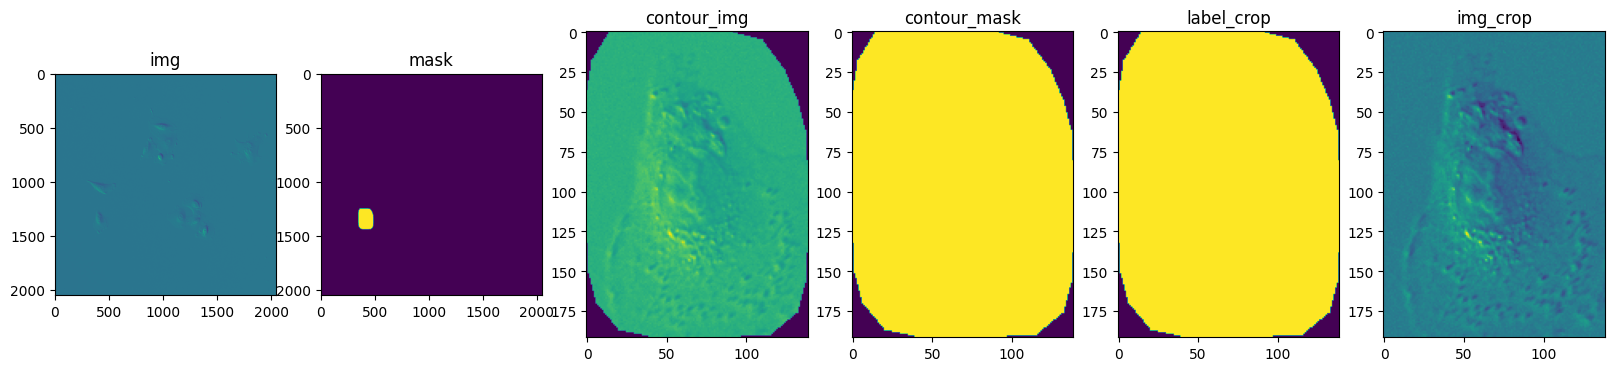

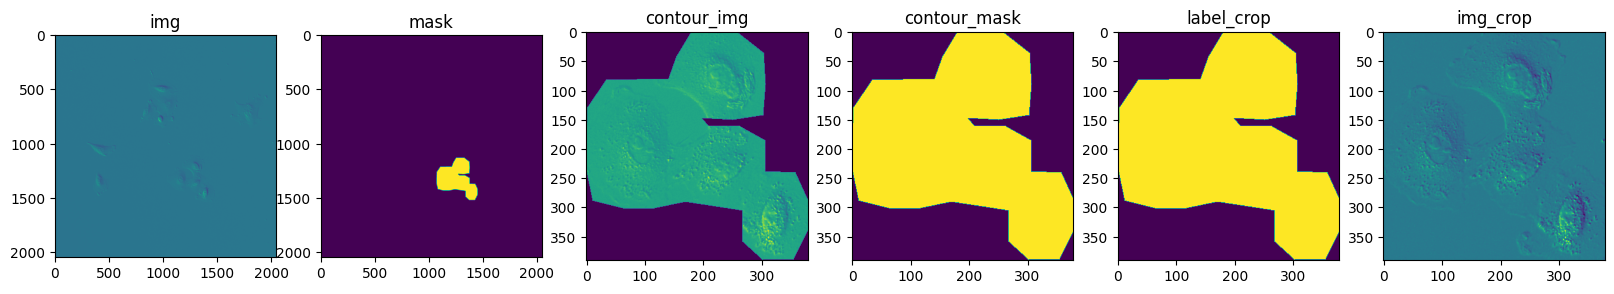

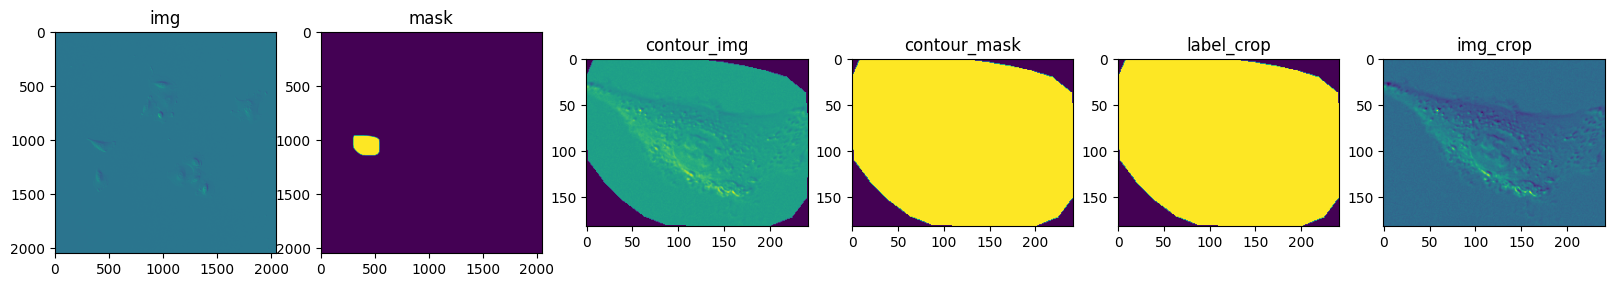

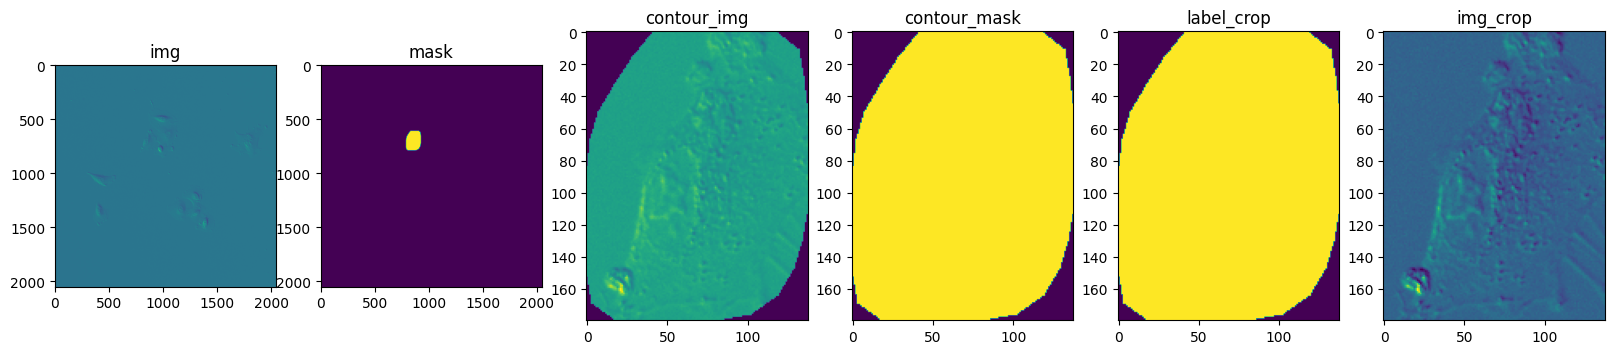

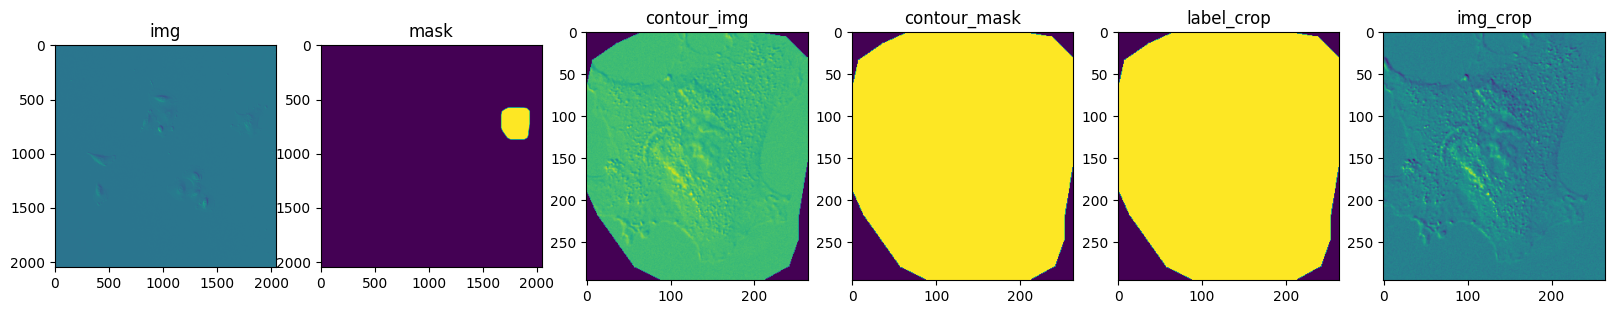

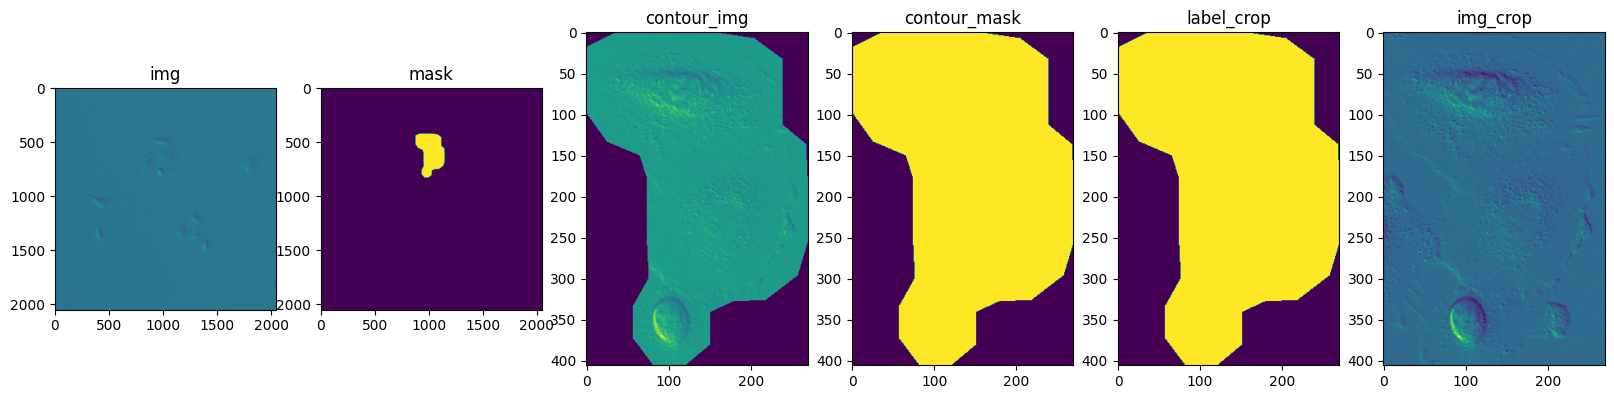

In [26]:
for sc in scs_1:
    sc.show_panel()
    plt.show()
    plt.close()